In [1]:
import pandas as pd

data = pd.read_csv('../resources/heart.csv')
data = data.dropna().drop_duplicates(ignore_index=True)

training_data = data.drop(columns=['output'])

data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
298,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
299,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
300,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [2]:
%matplotlib inline
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

In [3]:
def draw_umap(values, n_neighbors, min_dist, metric):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=0)
    
    embedding = reducer.fit_transform(values)
    
    colors = [sns.color_palette()[i] for i in data.sex]
    insafe_indexes = list(filter(lambda i: not data.output[i], range(len(data))))
    insafe = np.array([embedding[i] for i in insafe_indexes])
    insafe_colors = [colors[i] for i in insafe_indexes]
    atrisk_indexes = list(filter(lambda i: data.output[i], range(len(data))))
    atrisk = np.array([embedding[i] for i in atrisk_indexes])
    atrisk_colors = [colors[i] for i in atrisk_indexes]
    
    fig = plt.figure(figsize=(8, 8))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.scatter(insafe[:, 0], insafe[:, 1], c=insafe_colors, marker='o')
    subplot.scatter(atrisk[:, 0], atrisk[:, 1], c=atrisk_colors, marker='x')
    
    mcolor = sns.color_palette()[0]
    fcolor = sns.color_palette()[1]
    subplot.legend(
        handles=[
            mlines.Line2D([], [], linestyle='None', color=mcolor, marker='o', markersize=10, label='Male in safe'),
            mlines.Line2D([], [], linestyle='None', color=mcolor, marker='x', markersize=10, label='Male at risk'),
            mlines.Line2D([], [], linestyle='None', color=fcolor, marker='o', markersize=10, label='Female in safe'),
            mlines.Line2D([], [], linestyle='None', color=fcolor, marker='x', markersize=10, label='Female at risk')],
        loc='lower right',
        framealpha=0.6,
        ncol=2)
    
    plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}')
    
    return embedding

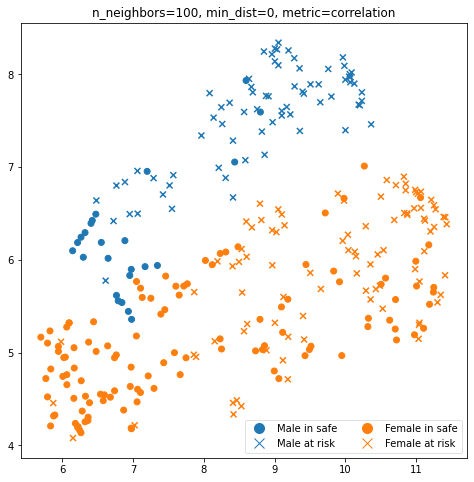

In [4]:
from sklearn.preprocessing import StandardScaler

scaled__training_data_values = StandardScaler().fit_transform(training_data.values)
embedding = draw_umap(scaled__training_data_values, n_neighbors=100, min_dist=0, metric='correlation')

#for n in [5, 10, 15, 20, 30, 40, 60, 80, 100]:
#    for m in ['euclidean', 'manhattan', 'cosine', 'correlation', 'braycurtis', 'canberra']:
#        draw_umap(scaled_data_values, n_neighbors=n, min_dist=0, metric=m)

### Делим выборку на обучающую и тестовую в соотношении 80/20

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    training_data,
    data['output'],
    test_size=0.2,
    random_state=0)

### Обучаем классификатор на тренировном наборе ...

... затем запускаем на тестовом с последующим выводом процета правильно распознанных значений

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11, weights='distance', metric='manhattan')
knn.fit(x_train, y_train)
result = knn.predict(x_test)

sum(map(lambda a, b: a == b, result, y_test)) / len(y_test)

0.7213114754098361

### Строим матрицу ошибок

<table>
    <tr>
        <td rowspan=2>Прогноз</td><td colspan=2>Реальность</td>
    </tr>
    <tr>
        <td>+</td><td>-</td>
    </tr>
    <tr>
        <td>+</td><td>True Positive</td><td>False Positive</td>
    </tr>
    <tr>
        <td>-</td><td>False Negative</td><td>True Negative</td>
    </tr>
</table>

In [7]:
TP = sum(map(lambda a, b: a == b == 1, result, y_test))
FP = sum(map(lambda a, b: a == 1 != b, result, y_test))
FN = sum(map(lambda a, b: a == 0 != b, result, y_test))
TN = sum(map(lambda a, b: a == b == 0, result, y_test))

pd.DataFrame(
    [[TP, FP], [FN, TN]],
    columns=['Реальность 1', 'Реальность 0'],
    index=['Прогноз 1', 'Прогноз 0'])

,Реальность 1,Реальность 0
Прогноз 1,25,8
Прогноз 0,9,19


### Метрика $accuracy$

Доля правильных ответов системы ко всем её ответам

$$accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

In [8]:
accuracy = (TP + TN) / (TP + TN + FP + FN)

accuracy

0.7213114754098361

### Метрика $precision$

Точность предсказания системы (сколько реально беременных среди отмеченных системой как беременных)

$$precision = \frac{TP}{TP+FP}$$

In [9]:
precision1 = TP / (TP + FP)
precision0 = TN / (TN + FN)

[precision1, precision0]

[0.7575757575757576, 0.6785714285714286]

### Метрика $recall$

Полнота ответов системы (сколько беременных найдено из всех реально беременных).

$$recall = \frac{TP}{TP+FN}$$

In [10]:
recall1 = TP / (TP + FN)
recall0 = TN / (TN + FP)

[recall1, recall0]

[0.7352941176470589, 0.7037037037037037]

### Метрика $F_1$

$$F_1=2*\frac{precision*recall}{precision+recall}$$

In [11]:
f11 = 2 * precision1 * recall1 / (precision1 + recall1)
f10 = 2 * precision0 * recall0 / (precision0 + recall0)

[f11, f10]

[0.746268656716418, 0.6909090909090909]

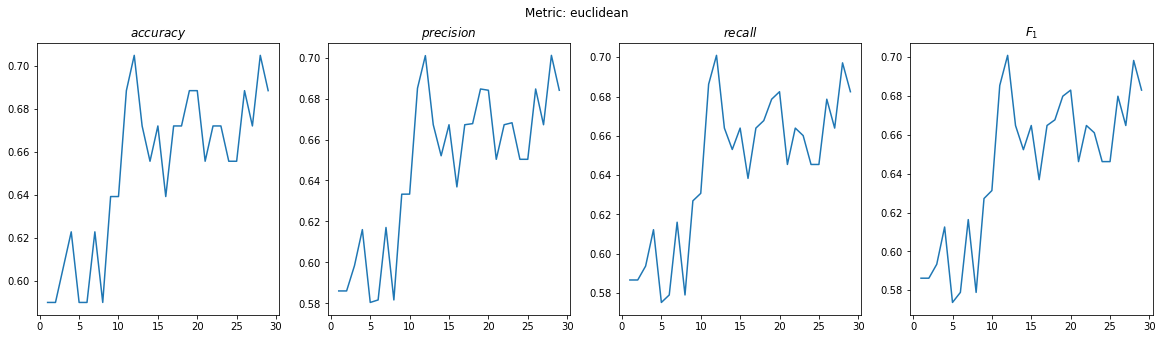

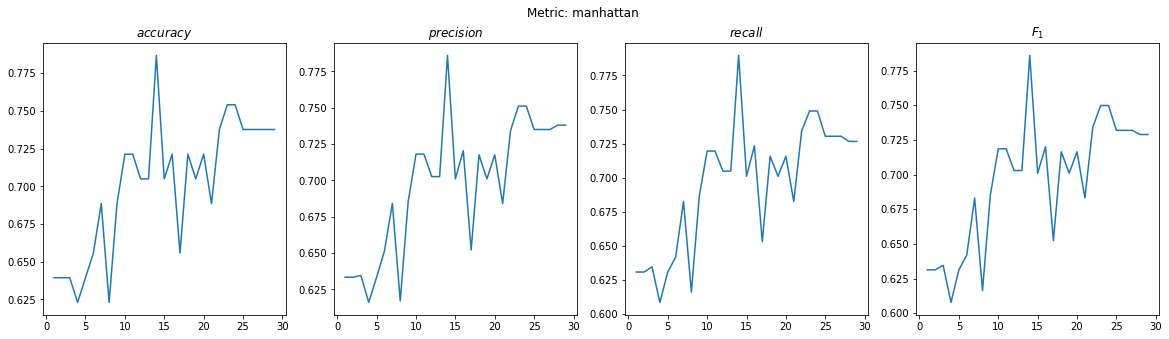

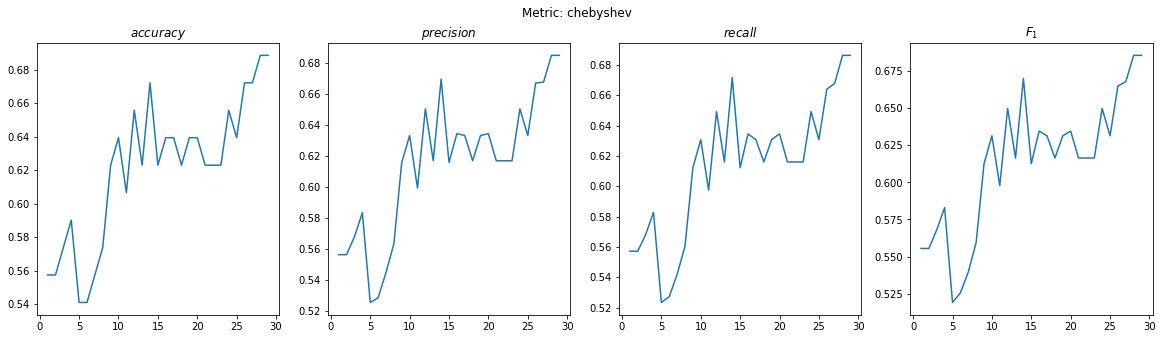

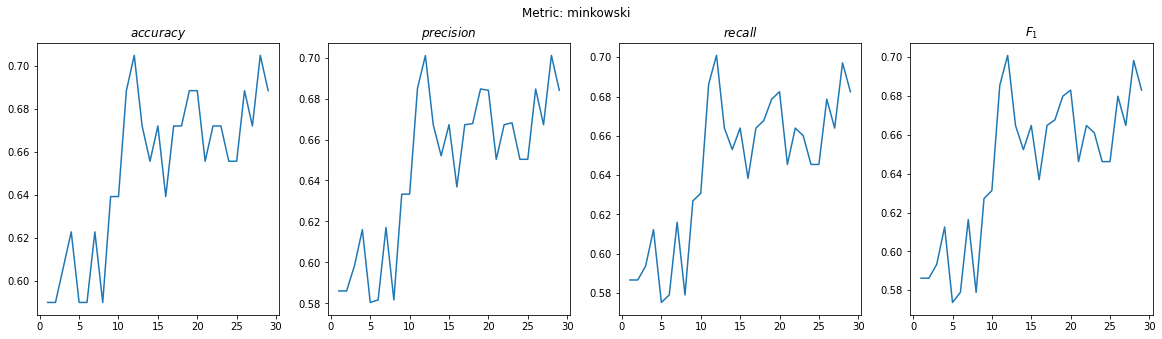

In [12]:
from sklearn.metrics import precision_recall_fscore_support

def calc_metrics_for_kneighbors(m):
    acc = []
    prec = []
    rec = []
    fs = []
    k_range = range(1, 30)

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric=m)
        knn.fit(x_train, y_train)
        result = knn.predict(x_test).tolist()

        metrics = precision_recall_fscore_support(y_test, result)
        
        acc.append(sum(map(lambda a, b: a == b, y_test, result)) / len(y_test))
        prec.append(np.average(metrics[0]))
        rec.append(np.average(metrics[1]))
        fs.append(np.average(metrics[2]))

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].plot(k_range, acc)
    ax[1].plot(k_range, prec)
    ax[2].plot(k_range, rec)
    ax[3].plot(k_range, fs)

    ax[0].set_title('$accuracy$')
    ax[1].set_title('$precision$')
    ax[2].set_title('$recall$')
    ax[3].set_title('$F_1$')

    fig.suptitle('Metric: ' + m)

for m in ['euclidean', 'manhattan', 'chebyshev', 'minkowski']:
    calc_metrics_for_kneighbors(m)

### Логистическая регрессия

/Users/nikita/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikita/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikita/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikita/op

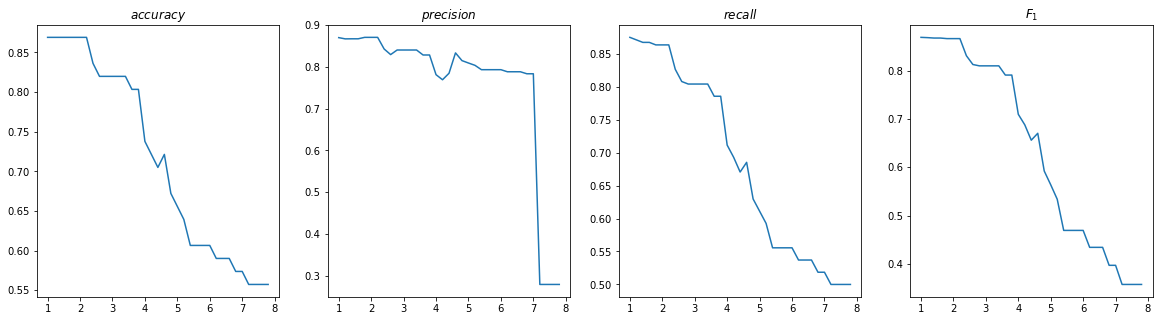

In [17]:
from sklearn.linear_model import LogisticRegression

def calc_metrics_for_logistic_regression():
    acc = []
    prec = []
    rec = []
    fs = []
    inter_range = np.arange(1, 8, 0.2)

    for inter in inter_range:
        model = LogisticRegression(max_iter=1000)
        model.fit(x_train, y_train)
        model.intercept_ = inter
        result = model.predict(x_test).tolist()
        
        metrics = precision_recall_fscore_support(y_test, result)
        
        acc.append(sum(map(lambda a, b: a == b, y_test, result)) / len(y_test))
        prec.append(np.average(metrics[0]))
        rec.append(np.average(metrics[1]))
        fs.append(np.average(metrics[2]))

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    ax[0].plot(inter_range, acc)
    ax[1].plot(inter_range, prec)
    ax[2].plot(inter_range, rec)
    ax[3].plot(inter_range, fs)

    ax[0].set_title('$accuracy$')
    ax[1].set_title('$precision$')
    ax[2].set_title('$recall$')
    ax[3].set_title('$F_1$')
    
calc_metrics_for_logistic_regression()

### Дерево принятия решений

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)
tree.fit(x_train, y_train)
result = tree.predict(x_test)

accuracy = sum(map(lambda a, b: a == b, y_test, result)) / len(y_test)
accuracy

0.8360655737704918

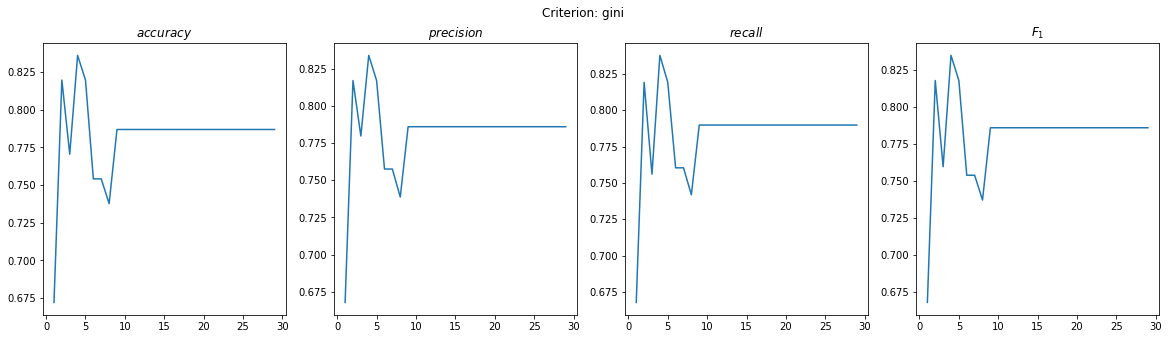

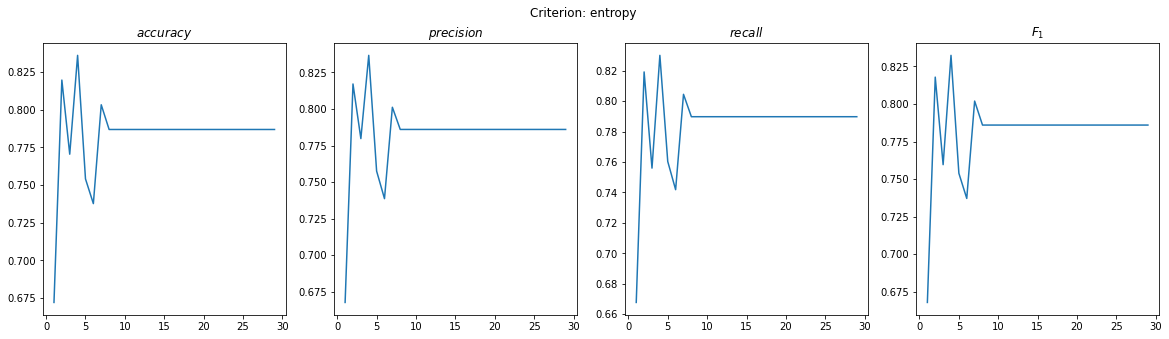

In [15]:
def calc_metrics_for_tree(crit):
    acc = []
    prec = []
    rec = []
    fs = []
    d_range = range(1, 30)

    for d in d_range:
        knn = DecisionTreeClassifier(criterion=crit, max_depth=d, random_state=0)
        knn.fit(x_train, y_train)
        result = knn.predict(x_test).tolist()

        metrics = precision_recall_fscore_support(y_test, result)
        
        acc.append(sum(map(lambda a, b: a == b, y_test, result)) / len(y_test))
        prec.append(np.average(metrics[0]))
        rec.append(np.average(metrics[1]))
        fs.append(np.average(metrics[2]))

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].plot(d_range, acc)
    ax[1].plot(d_range, prec)
    ax[2].plot(d_range, rec)
    ax[3].plot(d_range, fs)

    ax[0].set_title('$accuracy$')
    ax[1].set_title('$precision$')
    ax[2].set_title('$recall$')
    ax[3].set_title('$F_1$')

    fig.suptitle('Сriterion: ' + crit)
    
for c in ['gini', 'entropy']:
    calc_metrics_for_tree(c)

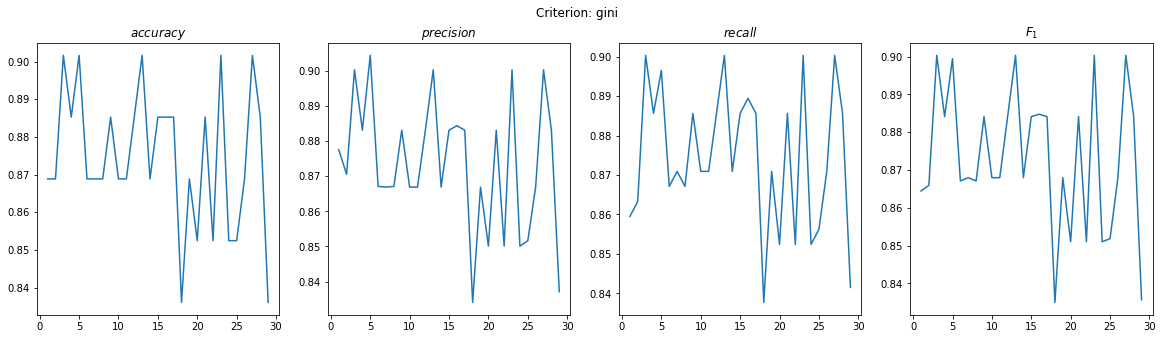

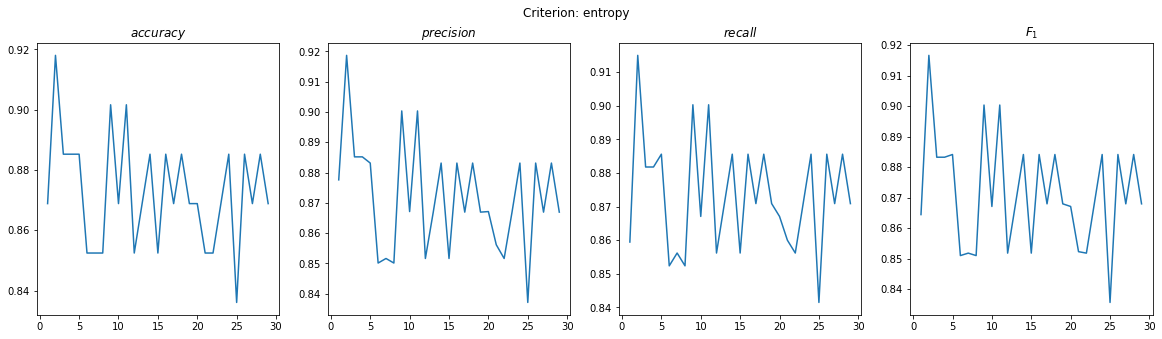

In [16]:
from sklearn.ensemble import RandomForestClassifier

def calc_metrics_for_forest(crit):
    acc = []
    prec = []
    rec = []
    fs = []
    d_range = range(1, 30)

    for d in d_range:
        knn = RandomForestClassifier(criterion=crit, max_depth=d)
        knn.fit(x_train, y_train)
        result = knn.predict(x_test).tolist()
        
        metrics = precision_recall_fscore_support(y_test, result)
        
        acc.append(sum(map(lambda a, b: a == b, y_test, result)) / len(y_test))
        prec.append(np.average(metrics[0]))
        rec.append(np.average(metrics[1]))
        fs.append(np.average(metrics[2]))

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    ax[0].plot(d_range, acc)
    ax[1].plot(d_range, prec)
    ax[2].plot(d_range, rec)
    ax[3].plot(d_range, fs)

    ax[0].set_title('$accuracy$')
    ax[1].set_title('$precision$')
    ax[2].set_title('$recall$')
    ax[3].set_title('$F_1$')

    fig.suptitle('Criterion: ' + crit)
    
for c in ['gini', 'entropy']:
    calc_metrics_for_forest(c)